#Trabajo Pŕactico N°6: Modelos de estado para sistemas estocásticos de tiempo discreto

Actividad:

1. Usando el sistema del péndulo invertido, establecer un modelo de ruido para simular
incertidumbre en la medición del estado y en la de la salida, asumiendo que los sensores
tienen error con media nula y sigma 0, 0.01, 0.02, 0.05 y 0.1, es decir, son 5 clases de
ruido, con F y G iguales a la matriz identidad. Esto indica que es necesario el empleo de
un Observador de Luenberger.

  Diseñar un controlador que estabilice al sistema y acelere la dinámica mediante:

 A. Diseño con LQR, por lo que no se tendría en cuenta a F y a G en el diseño del controlador, midiendo ángulo y desplazamiento.

 B. Diseño con LQG, considerando las clases de ruido del punto 1, Es decir, a F y a G en el diseño del controlador, midiendo ángulo y desplazamiento.  



2. Repetir 1 para el caso del modelo del avión, empleando los mismos parámetros de ruido, midiendo ángulo con respecto a la horizontal $\phi$ y altura *h*




##Instalar e importar las librerías necesarias

In [3]:
!pip install -U control qtpy scienceplots

In [4]:
import numpy as np
from scipy import signal
import control as ctrl
import matplotlib.pyplot as plt
from control import TransferFunction
from control.matlab import lsim
import scienceplots
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)


#Caso de estudio 1: Péndulo invertido
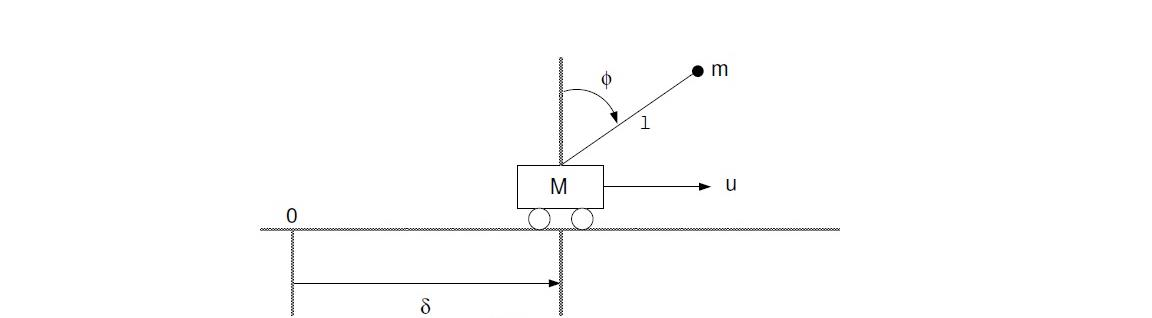

Donde las ecuaciones del sistema son:

$\begin{cases}
(M+m)\ddot{\delta} + ml\ddot{\phi}\cos\phi - ml\dot{\phi}^2\text{sen}\phi + F\dot{\delta} = u \\
l\ddot{\phi} - g\text{sen}\phi + \ddot{\delta}\cos\phi = 0
\end{cases}$

Se nos pide diseñar un observador y un controlador que estabilice el sistema y acelere la dinámica.

In [ ]:
#----- Configuración inicial -----#
np.random.seed(100)  # Equivalente a randn('state',100)
Realizaciones = 50  # Cantidad de realizaciones para Monte Carlo
sigma=0.05
alfa_0 = 0.8 #Condición inicial
sQ = sigma # Covarianza del ruido de estado
sR = sigma  # Covarianza del ruido de medición
m = 0.1; Fricc = 0.1; long = 0.6; g = 9.8; M = 0.5
TamanioFuente = 11
kmax = 1500
Ts = 0.01

#----- Matrices del sistema -----#
Mat_Ac = np.array([[0, 1, 0, 0],
                   [0, -Fricc/M, -m*g/M, 0],
                   [0, 0, 0, 1],
                   [0, Fricc/(long*M), g*(m+M)/(long*M), 0]])
Mat_Bc = np.array([[0], [1/M], [0], [-1/(long*M)]])
Mat_C = np.array([[1, 0, 0, 0],[0, 0, 1, 0]])
F_ = sQ * np.eye(4)  # Covarianza del ruido de estado
G_ = sR * np.eye(2)
I = np.eye(4)

#----- Discretización del sistema -----#
sys_c = ctrl.ss(Mat_Ac, Mat_Bc, Mat_C, 0)
sys_d = ctrl.c2d(sys_c, Ts, method='zoh')
Mat_A = sys_d.A
Mat_B = sys_d.B

#----- Matriz de controlabilidad -----#
Mat_M = np.hstack([Mat_B, Mat_A @ Mat_B, Mat_A @ Mat_A @ Mat_B, Mat_A @ Mat_A @ Mat_A @ Mat_B])
rango = np.linalg.matrix_rank(Mat_M)

#----- Matrices de diseño del controlador DLQG -----#
Aa = Mat_A; Ba = Mat_B
Q = np.diag([1e2, 1e1, 1e6, 1e1])
S = np.diag([1e1, 1e3, 1e6, 1e2])
P = S  # Condición inicial de P
R = 1e0

#----- Calculo de ganancias -----#
Kx = np.zeros((kmax, 4))
Kv = np.zeros((kmax, 4))
Ea = np.zeros((4, kmax),dtype=complex)  # Ajustamos las dimensiones de Ea
for hi in range(kmax-2, -1, -1):
    P = Q + Aa.T @ P @ Aa - Aa.T @ P @ Ba @ np.linalg.inv(R + Ba.T @ P @ Ba) @ Ba.T @ P @ Aa
    Kx[hi, :] = np.linalg.inv(R + Ba.T @ P @ Ba) @ Ba.T @ P @ Aa
    Kv[hi, :] = np.linalg.inv(R + Ba.T @ P @ Ba) @ Ba.T @ P @ F_
    Ea[:, hi] = np.linalg.eigvals(Aa - Ba @ Kx[hi, :].reshape(1, 4))  # Ajustamos la forma de Kx[hi, :]


#----- Observador -----#
A_dual=np.transpose(Mat_A)
B_dual=np.transpose(Mat_C)
C_dual=np.transpose(Mat_B)
Qo=np.diag([1e0,1e0,1e0,1e0])
Ro=np.diag([1e4,1e0])
Ko,_,_=ctrl.dlqr(A_dual,B_dual,Qo,Ro)
Ko=Ko.T
x0 = np.array([0, 0, -alfa_0, 0])

#----- Inicializacion -----#
Jmin = x0.T @ P @ x0
Jn_ = np.zeros((Realizaciones, kmax))
u = np.zeros((Realizaciones, kmax))
y_sal = np.zeros((Realizaciones, kmax))
p = np.zeros((Realizaciones, kmax))
p_p = np.zeros((Realizaciones, kmax))
alfa = np.zeros((Realizaciones, kmax))
omega = np.zeros((Realizaciones, kmax))
x_hat = np.zeros(4, dtype=np.float64)
x = np.zeros(4, dtype=np.float64)
Ys= np.zeros(2, dtype=np.float64)

#-------- Simulacion --------#

for trial in range(Realizaciones):
    v = np.random.randn(4, kmax)  # Ruido de estado escalado por sigma
    w = np.random.randn(2, kmax)  # Ruido de salida escalado por sigma
    x = x0 + F_ @ v[:, 0]

    p[trial, 0], p_p[trial, 0], alfa[trial, 0], omega[trial, 0] = x


    for ki in range(kmax-1):

        #____ Seleccionar el controlador a utilizar ____#
        u[trial, ki] = -Kx[0, :] @ x_hat; label="LQR"; color="b" # LQR

        #u[trial, ki] = -(Kx[0, :] @ x_hat) - (Kv[0,:] @ v[:,ki]); label="LQG"; color="r" # LQG
        Jn_[trial, ki+1] = Jn_[trial, ki] + (x.T @ Q @ x + u[trial, ki] * R * u[trial, ki])
        Ys=Mat_C@x + G_@w[:,ki]

        y_sal[trial, ki] = Ys[0]  # Ruido de salida con G = 1
        x = mopdm2(Ts, x, u[trial, ki]) + F_ @ v[:, ki+1] #Simulacion del sistema

        Y_o=(Mat_C@x_hat)
        x_hat =Mat_A@x_hat+np.transpose( Mat_B *u[trial,ki])[0]+Ko @ (Ys-Y_o)

        p[trial, ki+1], p_p[trial, ki+1], alfa[trial, ki+1], omega[trial, ki+1] = x

    Jn_[trial, ki+1] += x.T @ S @ x
    u[trial, ki+1] = -Kx[1, :] @ x - Kv[1, :] @ v[:, ki]

Jn = np.mean(Jn_, axis=0)
print(f"El valor de costo es Jn(end)={Jn[-1]:.4f}. Alfa(1)={alfa_0}, sigma={sigma}.")


El valor de costo es Jn(end)=32950478.1442. Alfa(1)=0.8, sigma=0.05.


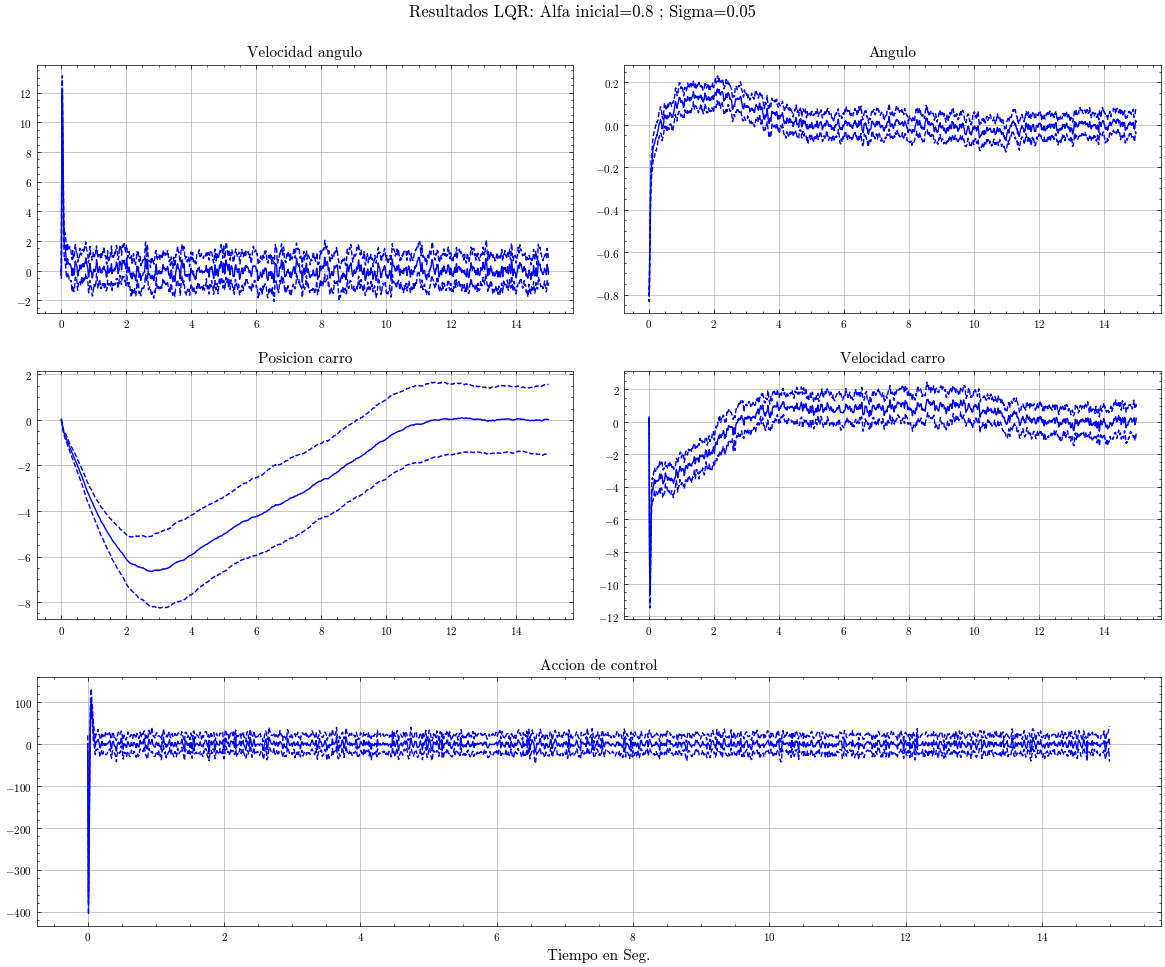

In [ ]:
# Graficar todas las simulaciones
t = np.arange(kmax) * Ts
plt.style.use(["science","ieee","no-latex"])
plt.figure(figsize=(12, 10),dpi=100)

# Subgráfico 1: Velocidad angular
plt.subplot(3, 2, 1); plt.grid(True); plt.title(f'Velocidad angulo', fontsize=TamanioFuente)
plt.plot(t, np.mean(omega, axis=0), color)
plt.plot(t, np.mean(omega, axis=0) + 0.5 * np.sqrt(np.var(omega, axis=0)), color + '--')
plt.plot(t, np.mean(omega, axis=0) - 0.5 * np.sqrt(np.var(omega, axis=0)), color + '--')

# Subgráfico 2: Ángulo
plt.subplot(3, 2, 2); plt.grid(True); plt.title(f'Angulo', fontsize=TamanioFuente)
plt.plot(t, np.mean(alfa, axis=0), color)
plt.plot(t, np.mean(alfa, axis=0) + 0.5 * np.sqrt(np.var(alfa, axis=0)), color + '--')
plt.plot(t, np.mean(alfa, axis=0) - 0.5 * np.sqrt(np.var(alfa, axis=0)), color + '--')

# Subgráfico 3: Posición carro
plt.subplot(3, 2, 3); plt.grid(True); plt.title(f'Posicion carro', fontsize=TamanioFuente)
plt.plot(t, np.mean(p, axis=0), color)
plt.plot(t, np.mean(p, axis=0) + 0.5 * np.sqrt(np.var(p, axis=0)), color + '--')
plt.plot(t, np.mean(p, axis=0) - 0.5 * np.sqrt(np.var(p, axis=0)), color + '--')

# Subgráfico 4: Velocidad carro
plt.subplot(3, 2, 4); plt.grid(True); plt.title(f'Velocidad carro', fontsize=TamanioFuente)
plt.plot(t, np.mean(p_p, axis=0), color)
plt.plot(t, np.mean(p_p, axis=0) + 0.5 * np.sqrt(np.var(p_p, axis=0)), color + '--')
plt.plot(t, np.mean(p_p, axis=0) - 0.5 * np.sqrt(np.var(p_p, axis=0)), color + '--')

# Subgráfico 5: Acción de control
plt.subplot(3, 1, 3); plt.grid(True); plt.title(f'Accion de control', fontsize=TamanioFuente)
plt.xlabel('Tiempo en Seg.', fontsize=TamanioFuente)
plt.plot(t, np.mean(u, axis=0), color)
plt.plot(t, np.mean(u, axis=0) + 0.5 * np.sqrt(np.var(u, axis=0)), color + '--')
plt.plot(t, np.mean(u, axis=0) - 0.5 * np.sqrt(np.var(u, axis=0)), color + '--')

plt.suptitle(f"Resultados {label}: Alfa inicial={alfa_0} ; Sigma={sigma}", fontsize=TamanioFuente+1,fontweight="bold")
plt.tight_layout(pad=2)
plt.show()

In [ ]:
def mopdm2(tiempo_etapa, xant, accion):
    m = 0.1; Fricc = 0.1; long = 0.6; g = 9.8; M = 0.5
    h = 0.01
    p, p_p, alfa, omega = xant
    tita_pp = 0
    for _ in range(int(tiempo_etapa / h)):
        p_pp = (1/(M + m)) * (accion - m * long * tita_pp * np.cos(alfa) +
                               m * long * omega**2 * np.sin(alfa) - Fricc * p_p)
        tita_pp = (1/long) * (g * np.sin(alfa) - p_pp * np.cos(alfa))
        p_p += h * p_pp
        p += h * p_p
        omega += h * tita_pp
        alfa += h * omega
    return np.array([p, p_p, alfa, omega])


#Caso de estudio 2: Avión
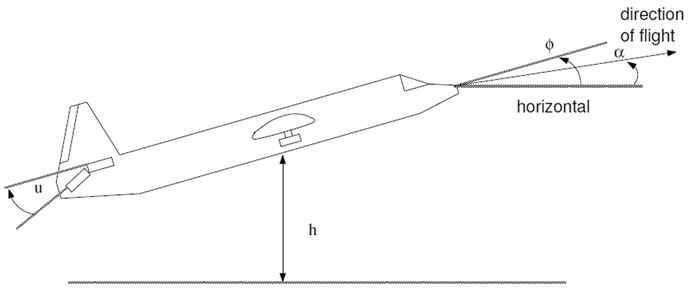

El sistema está definido por las ecuaciones:

$\begin{cases}
\dot{\alpha} = a (\phi - \alpha) \\
\ddot{\phi} = -\omega^2 (\phi - \alpha - \mathbf{b} \cdot \mathbf{u}) \\
\dot{\mathbf{h}} = c \alpha
\end{cases}$

Se realizará el mismo estudio que en el caso anterior, primero con un LQR y luego con un LQG

In [6]:
#----- Configuración inicial -----#
np.random.seed(100)  # Equivalente a randn('state',100)
Realizaciones = 50  # Cantidad de realizaciones para Monte Carlo
sigma=0.05
altura_0 = 500 #Condición inicial
sQ = sigma # Covarianza del ruido de estado
sR = sigma  # Covarianza del ruido de medición
a=0.07;
w=9;
b=5;
c=150;
TamanioFuente = 11
kmax = 2000
Ts = 0.01

#----- Matrices del sistema -----#
Mat_Ac = np.array([[-a, a, 0, 0],
                  [0, 0, 1, 0],
                  [w**2, -w**2, 0, 0],
                  [c, 0, 0, 0]])

Mat_Bc = np.array([[0], [0], [w**2 * b], [0]])

Mat_C = np.array([[0, 0, 0, 1],[0,1,0,0]])

D = 0
F_ = sQ * np.eye(4)  # Covarianza del ruido de estado
G_ = sR * np.eye(2)
I = np.eye(4)

#----- Discretización del sistema -----#
sys_c = ctrl.ss(Mat_Ac, Mat_Bc, Mat_C, 0)
sys_d = ctrl.c2d(sys_c, Ts, method='zoh')
Mat_A = sys_d.A
Mat_B = sys_d.B

#----- Matriz de controlabilidad -----#
Mat_M = np.hstack([Mat_B, Mat_A @ Mat_B, Mat_A @ Mat_A @ Mat_B, Mat_A @ Mat_A @ Mat_A @ Mat_B])
rango = np.linalg.matrix_rank(Mat_M)

#----- Matrices de diseño del controlador DLQG -----#
Aa = Mat_A; Ba = Mat_B
Q = np.diag([5, 5, 5, 1e-4])
#S = np.diag([1e1, 1e3, 1e6, 1e2])
S = np.diag([5, 5, 5, 1e-4])
P = S  # Condición inicial de P
R = 1e0

#----- Calculo de ganancias -----#
Kx = np.zeros((kmax, 4))
Kv = np.zeros((kmax, 4))
Ea = np.zeros((4, kmax),dtype=complex)  # Ajustamos las dimensiones de Ea
for hi in range(kmax-2, -1, -1):
    P = Q + Aa.T @ P @ Aa - Aa.T @ P @ Ba @ np.linalg.inv(R + Ba.T @ P @ Ba) @ Ba.T @ P @ Aa
    Kx[hi, :] = np.linalg.inv(R + Ba.T @ P @ Ba) @ Ba.T @ P @ Aa
    Kv[hi, :] = np.linalg.inv(R + Ba.T @ P @ Ba) @ Ba.T @ P @ F_
    Ea[:, hi] = np.linalg.eigvals(Aa - Ba @ Kx[hi, :].reshape(1, 4))  # Ajustamos la forma de Kx[hi, :]


#----- Observador -----#
A_dual=np.transpose(Mat_A)
B_dual=np.transpose(Mat_C)
C_dual=np.transpose(Mat_B)
Qo=np.diag([1e4,1e4,1e6,1e11])
Ro=np.diag([1e5,1e0])
Ko,_,_=ctrl.dlqr(A_dual,B_dual,Qo,Ro)
Ko=Ko.T
x0 = np.array([0, 0, 0, altura_0],dtype=np.float64)

#----- Inicializacion -----#
Jmin = x0.T @ P @ x0
Jn_ = np.zeros((Realizaciones, kmax))
u = np.zeros((Realizaciones, kmax))
y_sal = np.zeros((Realizaciones, kmax))

alfa = np.zeros((Realizaciones, kmax))
phi = np.zeros((Realizaciones, kmax))
phi_p = np.zeros((Realizaciones, kmax))
altura = np.zeros((Realizaciones, kmax))
x_hat = np.zeros(4, dtype=np.float64)
x = np.zeros(4, dtype=np.float64)
Ys= np.zeros(2, dtype=np.float64)

#-------- Simulacion --------#

for trial in range(Realizaciones):
    v = np.random.randn(4, kmax)  # Ruido de estado escalado por sigma
    w = np.random.randn(2, kmax)  # Ruido de salida escalado por sigma
    x = x0 + F_ @ v[:, 0]

    alfa[trial, 0], phi[trial, 0], phi_p[trial, 0], altura[trial, 0] = x


    for ki in range(kmax-1):

        #____ Seleccionar el controlador a utilizar ____#
        #u[trial, ki] = -Kx[0, :] @ x_hat; label="LQR"; color="b" # LQR
        u[trial, ki] = -(Kx[0, :] @ x_hat) - (Kv[0,:] @ v[:,ki]); label="LQG";color="r" # LQG

        Jn_[trial, ki+1] = Jn_[trial, ki] + (x.T @ Q @ x + u[trial, ki] * R * u[trial, ki])
        Ys=Mat_C@x + G_@w[:,ki]

        y_sal[trial, ki] = Ys[0]  # Ruido de salida con G = 1
        x = modavion(Ts, x, u[trial, ki]) + F_ @ v[:, ki+1] #Simulacion del sistema

        x_hat =Mat_A@x_hat+np.transpose( Mat_B *u[trial,ki])[0]+Ko @ (Ys-Mat_C@x_hat)

        alfa[trial, ki+1], phi[trial, ki+1], phi_p[trial, ki+1], altura[trial, ki+1] = x

    Jn_[trial, ki+1] += x.T @ S @ x
    u[trial, ki+1] = -Kx[1, :] @ x - Kv[1, :] @ v[:, ki]

Jn = np.mean(Jn_, axis=0)
print(f"El valor de costo es Jn(end)={Jn[-1]:.4f}. Altura(1)={altura_0}, sigma={sigma}.")


El valor de costo es Jn(end)=325632.1441. Altura(1)=500, sigma=0.05.


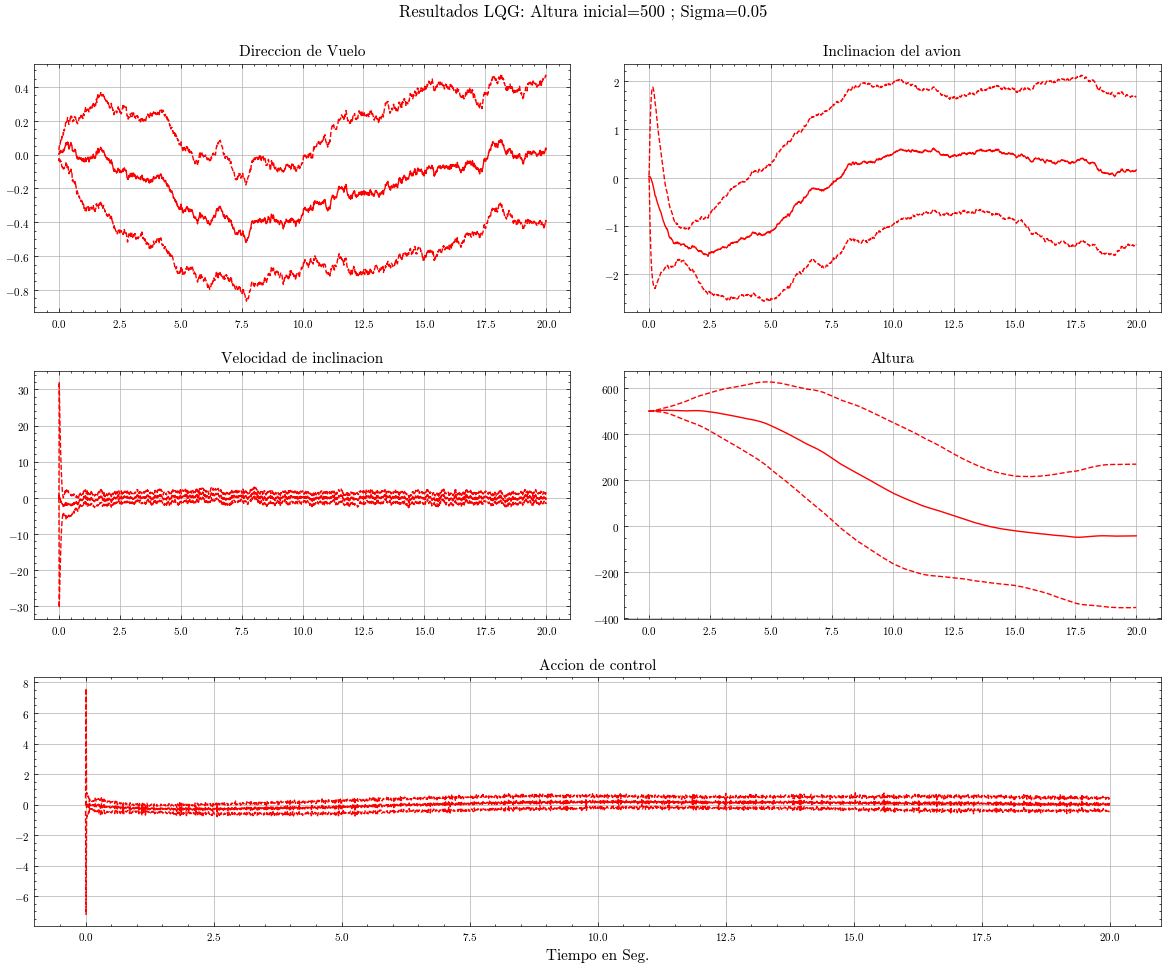

In [7]:
# Graficar todas las simulaciones
t = np.arange(kmax) * Ts
plt.style.use(["science","ieee","no-latex"])
plt.figure(figsize=(12, 10),dpi=100)

# Subgráfico 1: Dirección de Vuelo
plt.subplot(3, 2, 1); plt.grid(True); plt.title(f'Direccion de Vuelo', fontsize=TamanioFuente)
plt.plot(t, np.mean(alfa, axis=0), color)
plt.plot(t, np.mean(alfa, axis=0) + 0.5 * np.sqrt(np.var(alfa, axis=0)), color + '--')
plt.plot(t, np.mean(alfa, axis=0) - 0.5 * np.sqrt(np.var(alfa, axis=0)), color + '--')

# Subgráfico 2: Inclinación
plt.subplot(3, 2, 2); plt.grid(True); plt.title(f'Inclinacion del avion', fontsize=TamanioFuente)
plt.plot(t, np.mean(phi, axis=0), color)
plt.plot(t, np.mean(phi, axis=0) + 0.5 * np.sqrt(np.var(phi, axis=0)), color + '--')
plt.plot(t, np.mean(phi, axis=0) - 0.5 * np.sqrt(np.var(phi, axis=0)), color + '--')

# Subgráfico 3: Velocidad de inclinación
plt.subplot(3, 2, 3); plt.grid(True); plt.title(f'Velocidad de inclinacion', fontsize=TamanioFuente)
plt.plot(t, np.mean(phi_p, axis=0), color)
plt.plot(t, np.mean(phi_p, axis=0) + 0.5 * np.sqrt(np.var(phi_p, axis=0)), color + '--')
plt.plot(t, np.mean(phi_p, axis=0) - 0.5 * np.sqrt(np.var(phi_p, axis=0)), color + '--')

# Subgráfico 4: Altura del avion
plt.subplot(3, 2, 4); plt.grid(True); plt.title(f'Altura', fontsize=TamanioFuente)
plt.plot(t, np.mean(altura, axis=0), color)
plt.plot(t, np.mean(altura, axis=0) + 0.5 * np.sqrt(np.var(altura, axis=0)), color + '--')
plt.plot(t, np.mean(altura, axis=0) - 0.5 * np.sqrt(np.var(altura, axis=0)), color + '--')

# Subgráfico 5: Acción de control
plt.subplot(3, 1, 3); plt.grid(True); plt.title(f'Accion de control', fontsize=TamanioFuente)
plt.xlabel('Tiempo en Seg.', fontsize=TamanioFuente)
plt.plot(t, np.mean(u, axis=0), color)
plt.plot(t, np.mean(u, axis=0) + 0.5 * np.sqrt(np.var(u, axis=0)), color + '--')
plt.plot(t, np.mean(u, axis=0) - 0.5 * np.sqrt(np.var(u, axis=0)), color + '--')

plt.suptitle(f"Resultados {label}: Altura inicial={altura_0} ; Sigma={sigma}", fontsize=TamanioFuente+1,fontweight="bold")
plt.tight_layout(pad=2)
plt.show()


In [5]:
##----- Funcion de simulacion del avion -----##
def modavion(Ts, estado, accion):
    a = 0.07
    w = 9
    b = 5
    c = 150
    T0 = 1e-3  # Debe ser menor que Ts
    A = np.array([[-a, a, 0, 0],
                  [0, 0, 1, 0],
                  [w**2, -w**2, 0, 0],
                  [c, 0, 0, 0]])
    B = np.array([[0], [0], [w**2 * b], [0]])
    X = np.array([estado[0], estado[1], estado[2], estado[3]])
    for _ in range(int(Ts / T0)):
        Xp = A @ X + B @ np.array([accion])
        X = X + Xp * T0
    return X
